# Group_29 Project Phase 4

## Table of Contents

1. [Overview](#Overview)
2. [Connecting to DB](#Connecting-to-DB)
3. [Part A](#Part-A)
    - [Data Summarization](#Data-Summarization)
    - [Data Transformation Notes](#Data-Transformation-Notes)
4. [Part B](#Part-B)
    - [Data Preprocessing](#Data-Preprocessing)
    - [Decision Tree](#Decision-Tree)
    - [Gradient Boosting](#Gradient-Boosting)
    - [Random Forest](#Random-Forest)
    - [Table of Results And Summary](#Table-of-Results-And-Summary)
    - [Actionable Knowledge Nuggets And Summary](#Actionable-Knowledge-Nuggets-And-Summary)

## Overview

For the fourth and final phase of our CSI4142 project, we'll be performing some data mining in order to turn our raw data into useful information. As a first step, it's crucial that we identify what exactly it is we wish to predict. In our case, we'll be looking at the `age group of a patient who's tested positive for COVID-19`. As a result, the features we think will best train our model are:

1. Outbreak Related
2. Grocery and Pharmacy
3. Parks
4. Total Resolved
5. Total Unresolved
6. Total Fatal
7. City
8. Acquisition Group

## Connecting to DB

In this first part, we'll be connecting to our database and fetching our labels and features

In [1]:
import sys
sys.path.insert(1, '../lib/python3.9/site-packages')
from configparser import ConfigParser
import psycopg2
import numpy as np
import pandas as pd
import time
import matplotlib as mp
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.metrics import recall_score, precision_score, accuracy_score
#Can be very helpful to notice any imbalance in classes
from collections import Counter 

Now i can try to connect to my PSQL server

In [2]:
def config(filename='database.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

Get the configuration file as a python dictionary

In [3]:
cfg = config()

Establish the connection and create a cursor to the database

In [4]:
try:
    print("Attempting to connect to the database")
    conn = psycopg2.connect(**cfg)
    cursor = conn.cursor()
    print("Connection Successful")
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Attempting to connect to the database
Connection Successful


We'll now attempt to get our data

In [5]:
try:
    #Lets get our data 
    cursor.execute('''
                    select phu.city, p.acquisition_group, p.age_group, 
                    m.grocery_and_pharmarcy, m.parks,
                    f.total_resolved, f.total_unresolved, f.total_fatal
                    from  covid_19_tracking_fact_table f, phu_location_dimension phu,
                    patient_dimension p, mobility_dimension m
                    where f.patient_key = p.patient_key
                    and f.phu_location_key = phu.phu_location_key
                    and f.mobility_key = m.mobility_key
                    group by (phu.city, p.acquisition_group, p.age_group, m.grocery_and_pharmarcy, 
                    m.parks, f.total_resolved, f.total_unresolved, f.total_fatal)''')



    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()
        
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
    print("Rolling back...")
    conn.rollback()
    print("Rolled back successfully")

In [6]:
#Ensure to run this cell at the end of all your experiments to close all connections
cursor.close()
conn.close()

In [7]:
result_df = pd.DataFrame(result_list, columns=["city","acquisition_group","age_group", "grocery_and_pharmacy",
                                               "parks","total_resolved", "total_unresolved","total_fatal"])

In [8]:
result_df.head()

city acquisition_group age_group  grocery_and_pharmacy  parks  \
0  Mississauga                CC       20s                   -79     25   
1  Mississauga                CC       20s                   -79     25   
2  Mississauga                CC       20s                   -79     25   
3  Mississauga                CC       20s                   -79     25   
4  Mississauga                CC       20s                   -79     25   

   total_resolved  total_unresolved  total_fatal  
0               1                 0            0  
1               2                 0            0  
2               3                 0            0  
3               4                 0            0  
4               5                 0            0

## Part A

### Data Summarization

We will now use some summarization techniques to get a better understanding of our data. First and foremost we want to see if there's an imbalance in our classes

In [9]:
Counter(result_df['age_group'])

Counter({'20s': 4986,
         '30s': 4293,
         '40s': 4115,
         '50s': 4258,
         '60s': 3341,
         '70s': 2441,
         '80s': 2260,
         '90+': 1375,
         '<20': 4109})

We notice that there isn't too large of an imbalance between the classes. If we wind up noticing that our results aren't accurate enough, we can consider undersampling, but for now, we believe that this won't be needed

Next, we wanna see if there's any correlation between parks, grocery and pharmacy

<AxesSubplot:xlabel='parks', ylabel='grocery_and_pharmacy'>

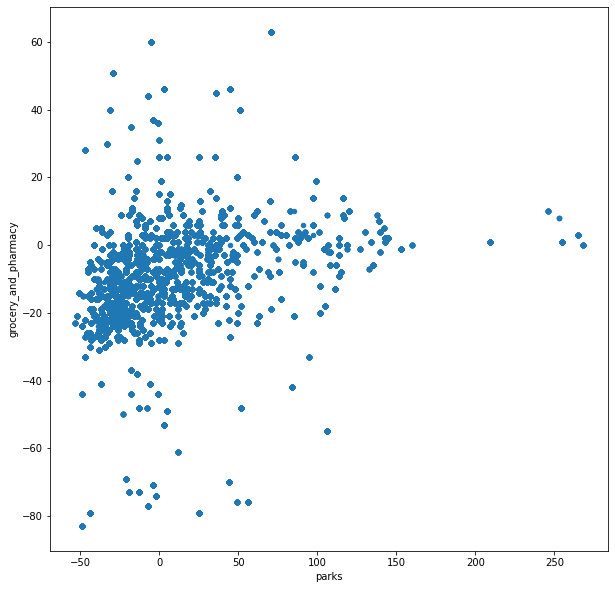

In [10]:
result_df.plot.scatter(x='parks',y='grocery_and_pharmacy',figsize=(10,10))

As expected, the correlation isn't too strong

The last thing we wanna do is check some of the tendencies of our data. Namely, the standard deviation and mean. These values will help give us an understanding of what our data looks like

In [11]:
result_df.mean()

grocery_and_pharmacy   -8.877638
parks                   6.351402
total_resolved          1.702162
total_unresolved        0.002406
total_fatal             0.058374
dtype: float64

In [12]:
result_df.std()

grocery_and_pharmacy    17.771206
parks                   43.500605
total_resolved           1.412923
total_unresolved         0.049639
total_fatal              0.255909
dtype: float64

### Data Transformation Notes

1. Since we wish to predict a patient's age group, using totals won't be of much help. Actually, it'll make things much more difficult for us. As a result, we'll need to update our dataframe to go from totals, to individual outcomes. To do so, we'll just need to go row-by-row and, for the outcome where the total is greater than 0, we replace it with 1. We'll also need to change the column names from `total_fatal`, `total_resolved` and `total_unresolved` to just `fatal`,`resolved` and `unresovled`, respectively.

2. When we were working on our phase 2 of the project, we made it a goal of ours to find any missing values in any of the datasets. As a result, our datamart is already populated in a way where no values are missing. Here's how we dealt with missing values:
    1. The weather data had some rows where the value 'E' was placed for all columns, indicating that the weather was not gathered for that day. Since in the four months that we were analysing, only one day had missing values, we decided to simply remove that entry.
    2. For the patients data, there were missing values for the outbreak related column. It was found to be only `yes` or it was blank. For these, it was assumed that if it was not related to an outbreak, that we would assign `no` instead of blank.
    3. Some special measures had missing end dates. For these, we assumed that the end date was 28 days after the start date

3. `outbreak_related` is binary. Since the outcomes are equally important, we'll be assigning `True` a value of 1 and `False` a value of 0
4. Based on our current understanding of the data, there isn't a clear imbalance between the classes. For now, we won't be performing any under-sampling. If, while training our model, we aren't happy with our results, we can consider under-sampling some of the classes that appear to have larger values than the others.
5. Finally, a word on our feature selection. We wanted to choose features that would best describe a person's age group. For example, we feel like parks, grocery and pharmacy represents a wide spectrum of places visited by different age groups, and so we chose it as a feature. Similarly, an outbreak could have different impacts on different age groups, and so it was also included. As for the outcome, we noticed from the last deliverable that there's a difference in outcome based on a person's age group, and so we think it'll help our model. These features are not set in stone, and we could revisit them after we complete part B to see if we can add/remove some features to improve our results. As of the first iteration (April 8th 2021) the features we're using are:
    1. Outbreak Related
    2. Keyword1
    3. Grocery and Pharmacy
    4. Parks
    5. Total Resolved
    6. Total Unresolved
    7. Total Fatal
    8. Acquisition Group
    
  Second iteration (April 12th 2021): 
  - We've decided to remove the `keyword1` feature since we noticed it doesn't provide much information on the age group of a patient. We repalced it with `city`, since different cities could have different distribution of age groups. We also added `acquisition_group` since people of different ages could have acquired the virus in different way. These attributes are categorical, so they will have to be one-hot encoded
  - Since `acquisition_group` includes a value `OB` representing an outbreak related case, we've decided to remove the `outbreak_related` feature, to avoid duplicates
  - The number of classes we're evaluating is too large, hence we've lowered the level of granularity by distributing the age groups into the following classes:
      - <20 and 20s: Youth
      - 30s, 40s and 50s: Adult
      - 60s, 70s, 80s and 90>: Senior
    
    since this change of classes presented an imbalance, we will be `under-sampling`

## Part B

### Data Preprocessing

First and foremost, we'll move from totals to singular outcomes

In [13]:
for i,row in result_df.iterrows():
    if(result_df.at[i,'total_resolved'] > 0):
        result_df.at[i,'total_resolved'] = 1
        
    elif(result_df.at[i,'total_unresolved'] > 0):
        result_df.at[i,'total_unresolved'] = 1
        
    elif(result_df.at[i,'total_fatal'] > 0):
        result_df.at[i,'total_fatal'] = 1
result_df = result_df.rename(columns={'total_resolved':'resolved','total_unresolved':'unresolved','total_fatal':'fatal'})
result_df = result_df.astype({'resolved':'bool','unresolved':'bool','fatal':'bool'})
result_df.head()

city acquisition_group age_group  grocery_and_pharmacy  parks  \
0  Mississauga                CC       20s                   -79     25   
1  Mississauga                CC       20s                   -79     25   
2  Mississauga                CC       20s                   -79     25   
3  Mississauga                CC       20s                   -79     25   
4  Mississauga                CC       20s                   -79     25   

   resolved  unresolved  fatal  
0      True       False  False  
1      True       False  False  
2      True       False  False  
3      True       False  False  
4      True       False  False

Next, we'll modify our age_group class

In [14]:
for i,row in result_df.iterrows():
    if(result_df.at[i,'age_group'] == '<20' or result_df.at[i,'age_group'] == '20s'):
        result_df.at[i,'age_group'] = 'youth'
        
    elif(result_df.at[i,'age_group'] == '30s' or result_df.at[i,'age_group'] == '40s' or result_df.at[i,'age_group'] == '50s'):
        result_df.at[i,'age_group'] = 'adult'
        
    else:
        result_df.at[i,'age_group'] = 'senior'
result_df = result_df.rename(columns={'total_resolved':'resolved','total_unresolved':'unresolved','total_fatal':'fatal'})
result_df.head()

city acquisition_group age_group  grocery_and_pharmacy  parks  \
0  Mississauga                CC     youth                   -79     25   
1  Mississauga                CC     youth                   -79     25   
2  Mississauga                CC     youth                   -79     25   
3  Mississauga                CC     youth                   -79     25   
4  Mississauga                CC     youth                   -79     25   

   resolved  unresolved  fatal  
0      True       False  False  
1      True       False  False  
2      True       False  False  
3      True       False  False  
4      True       False  False

Let's see if, now, we get any imbalance in our classes

In [15]:
Counter(result_df['age_group'])

Counter({'youth': 9095, 'adult': 12666, 'senior': 9417})

There's now a slight imbalance, which we'll need to take care of before using this data in our models

Finally, we one-hot encode the city and acquisition_group features

In [16]:
result_df = pd.get_dummies(result_df,columns=['city','acquisition_group'])
result_df.head()

age_group  grocery_and_pharmacy  parks  resolved  unresolved  fatal  \
0     youth                   -79     25      True       False  False   
1     youth                   -79     25      True       False  False   
2     youth                   -79     25      True       False  False   
3     youth                   -79     25      True       False  False   
4     youth                   -79     25      True       False  False   

   city_Mississauga  city_Newmarket  city_Oakville  city_Ottawa  city_Toronto  \
0                 1               0              0            0             0   
1                 1               0              0            0             0   
2                 1               0              0            0             0   
3                 1               0              0            0             0   
4                 1               0              0            0             0   

   city_Whitby  acquisition_group_CC  acquisition_group_MISSING INFORMATION  \
0            0                     1                                      0   
1            0                     1                                      0   
2            0                     1                                      0   
3            0                     1                                      0   
4            0                     1                                      0   

   acquisition_group_NO KNOWN EPI LINK  acquisition_group_OB  \
0                                    0                     0   
1                                    0                     0   
2                                    0                     0   
3                                    0                     0   
4                                    0                     0   

   acquisition_group_TRAVEL  acquisition_group_UNSPECIFIED EPI LINK  
0                         0                                       0  
1                         0                                       0  
2                         0                                       0  
3                         0                                       0  
4                         0                                       0

We can now begin seperating our features from our labels

In [17]:
# Labels
y = result_df['age_group']
result_df.drop(columns=['age_group'], inplace=True)

# Features
X = result_df
X.head()

grocery_and_pharmacy  parks  resolved  unresolved  fatal  city_Mississauga  \
0                   -79     25      True       False  False                 1   
1                   -79     25      True       False  False                 1   
2                   -79     25      True       False  False                 1   
3                   -79     25      True       False  False                 1   
4                   -79     25      True       False  False                 1   

   city_Newmarket  city_Oakville  city_Ottawa  city_Toronto  city_Whitby  \
0               0              0            0             0            0   
1               0              0            0             0            0   
2               0              0            0             0            0   
3               0              0            0             0            0   
4               0              0            0             0            0   

   acquisition_group_CC  acquisition_group_MISSING INFORMATION  \
0                     1                                      0   
1                     1                                      0   
2                     1                                      0   
3                     1                                      0   
4                     1                                      0   

   acquisition_group_NO KNOWN EPI LINK  acquisition_group_OB  \
0                                    0                     0   
1                                    0                     0   
2                                    0                     0   
3                                    0                     0   
4                                    0                     0   

   acquisition_group_TRAVEL  acquisition_group_UNSPECIFIED EPI LINK  
0                         0                                       0  
1                         0                                       0  
2                         0                                       0  
3                         0                                       0  
4                         0                                       0

Let's try to undersample

In [18]:
undersample = NearMiss(version=1, n_neighbors=3)
X,y = undersample.fit_resample(X,y)

Our data is now ready for use in our model

### Construct Models

First, divide the data into training and testing sets 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [20]:
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({'senior': 7288, 'youth': 7287, 'adult': 7253}) 
Test set Counter({'adult': 1842, 'youth': 1808, 'senior': 1807}) 


### Decision Tree

In [21]:
dt = DecisionTreeClassifier(criterion='entropy')
start_time = time.time()
dt.fit(X_train, y_train)
end_time = time.time()

In [22]:
y_pred = dt.predict(X_test)
recall = recall_score(y_pred, y_test,average='weighted') * 100
precision = precision_score(y_pred, y_test,average='weighted') * 100
accuracy = accuracy_score(y_pred, y_test) * 100
print("Accuracy of Decision Tree {:.2f} %".format(accuracy))
print("Recall of Decision Tree {:.2f} %".format(recall))
print("precision of Decision Tree {:.2f} %".format(precision))
print("Time to train Decision Tree {:.2f}s".format(end_time - start_time))

Accuracy of Decision Tree 37.24 %
Recall of Decision Tree 37.24 %
precision of Decision Tree 44.85 %
Time to train Decision Tree 0.12s


### Gradient Boosting

In [23]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in lr_list: 
    gb = GradientBoostingClassifier(learning_rate=learning_rate)
    start_time = time.time()
    gb.fit(X_train, y_train)
    end_time = time.time()
    y_pred = gb.predict(X_test)
    recall = recall_score(y_pred, y_test,average='weighted') * 100
    precision = precision_score(y_pred, y_test,average='weighted') * 100
    accuracy = accuracy_score(y_pred, y_test) * 100
    print("Learning Rate {:.2f}".format(learning_rate))    
    print("Accuracy of Gradient Boost {:.2f} %".format(accuracy))
    print("Recall of Gradient Boost {:.2f} %".format(recall))
    print("precision of Gradient Boost {:.2f} %".format(precision))
    print("Time to train Gradient Boost {:.2f}s\n".format(end_time - start_time))

Learning Rate 0.05
Accuracy of Gradient Boost 47.76 %
Recall of Gradient Boost 47.76 %
precision of Gradient Boost 53.96 %
Time to train Gradient Boost 3.96s

Learning Rate 0.07
Accuracy of Gradient Boost 47.17 %
Recall of Gradient Boost 47.17 %
precision of Gradient Boost 53.24 %
Time to train Gradient Boost 4.21s

Learning Rate 0.10
Accuracy of Gradient Boost 47.00 %
Recall of Gradient Boost 47.00 %
precision of Gradient Boost 52.08 %
Time to train Gradient Boost 4.07s

Learning Rate 0.25
Accuracy of Gradient Boost 46.38 %
Recall of Gradient Boost 46.38 %
precision of Gradient Boost 50.74 %
Time to train Gradient Boost 3.94s

Learning Rate 0.50
Accuracy of Gradient Boost 45.10 %
Recall of Gradient Boost 45.10 %
precision of Gradient Boost 48.70 %
Time to train Gradient Boost 3.99s

Learning Rate 0.75
Accuracy of Gradient Boost 43.56 %
Recall of Gradient Boost 43.56 %
precision of Gradient Boost 46.91 %
Time to train Gradient Boost 4.00s

Learning Rate 1.00
Accuracy of Gradient Boost 

### Random Forest

In [24]:
rf = RandomForestClassifier(criterion='entropy')
start_time = time.time()
rf.fit(X_train, y_train)
end_time = time.time()

In [25]:
y_pred = rf.predict(X_test)
recall = recall_score(y_pred, y_test,average='weighted') * 100
precision = precision_score(y_pred, y_test,average='weighted') * 100
accuracy = accuracy_score(y_pred, y_test) * 100
print("Accuracy of Random Forrest {:.2f} %".format(accuracy))
print("Recall of Random Forrest {:.2f} %".format(recall))
print("precision of Random Forrest {:.2f} %".format(precision))
print("Time to train Random Forrest {:.2f}s".format(end_time - start_time))

Accuracy of Random Forrest 36.01 %
Recall of Random Forrest 36.01 %
precision of Random Forrest 38.84 %
Time to train Random Forrest 1.40s


### Table of Results And Summary

| Algorithm     | Decision Tree | Gradient Boost | Random Forest |
|---------------|---------------|----------------|---------------|
| Accuracy      | 37.24%        | 47.76%         | 36.01%        |
| Precision     | 44.85%        | 53.96%         | 38.84%        |
| Recall        | 37.24%        | 47.76%         | 36.01%        |
| Time To Train | 0.12s         | 3.96s          | 1.40s         |

From the results in the table, we can conclude two things. Firstly, our results are not high enough, no matter what algorithm we use. This could be due to multiple reasons, but the main reason we think is due to the lack of data. Even with the addition/removal of features, our statistics would show very minimal improvments. That being said, however, Gradient Boost is the algorithm that performs the best, under our conditions. As the table demonstrates, it beats all other algorithms in every criteria, except for time. Indicating that Gradient Boosting is, indeed, slower than the two other algorithms, as learnt in class. Decision Tree comes in second, beating Random Forest. This is most likely due to the low amount of data that we have, since we know that Random Forest is ideal for problems with very large datasets. Something to note is the time it took to train our model using Decision Tree. For situations that prioritize faster run times, Decision Tree is definetly an option. One final point to take into consideration is interpretability. Since our model includes many features, interpreting the results of ensembles is much more difficult than it is to interpret the results of the decision tree.  

### Actionable Knowledge Nuggets And Summary

In [26]:
r = export_text(dt,feature_names=list(X.columns),max_depth=5)
print(r)

|--- fatal <= 0.50
|   |--- acquisition_group_OB <= 0.50
|   |   |--- acquisition_group_TRAVEL <= 0.50
|   |   |   |--- acquisition_group_CC <= 0.50
|   |   |   |   |--- city_Oakville <= 0.50
|   |   |   |   |   |--- city_Ottawa <= 0.50
|   |   |   |   |   |   |--- truncated branch of depth 33
|   |   |   |   |   |--- city_Ottawa >  0.50
|   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |--- city_Oakville >  0.50
|   |   |   |   |   |--- grocery_and_pharmacy <= -1.50
|   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |   |--- grocery_and_pharmacy >  -1.50
|   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |--- acquisition_group_CC >  0.50
|   |   |   |   |--- unresolved <= 0.50
|   |   |   |   |   |--- city_Newmarket <= 0.50
|   |   |   |   |   |   |--- truncated branch of depth 29
|   |   |   |   |   |--- city_Newmarket >  0.50
|   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |--- unresolved >  

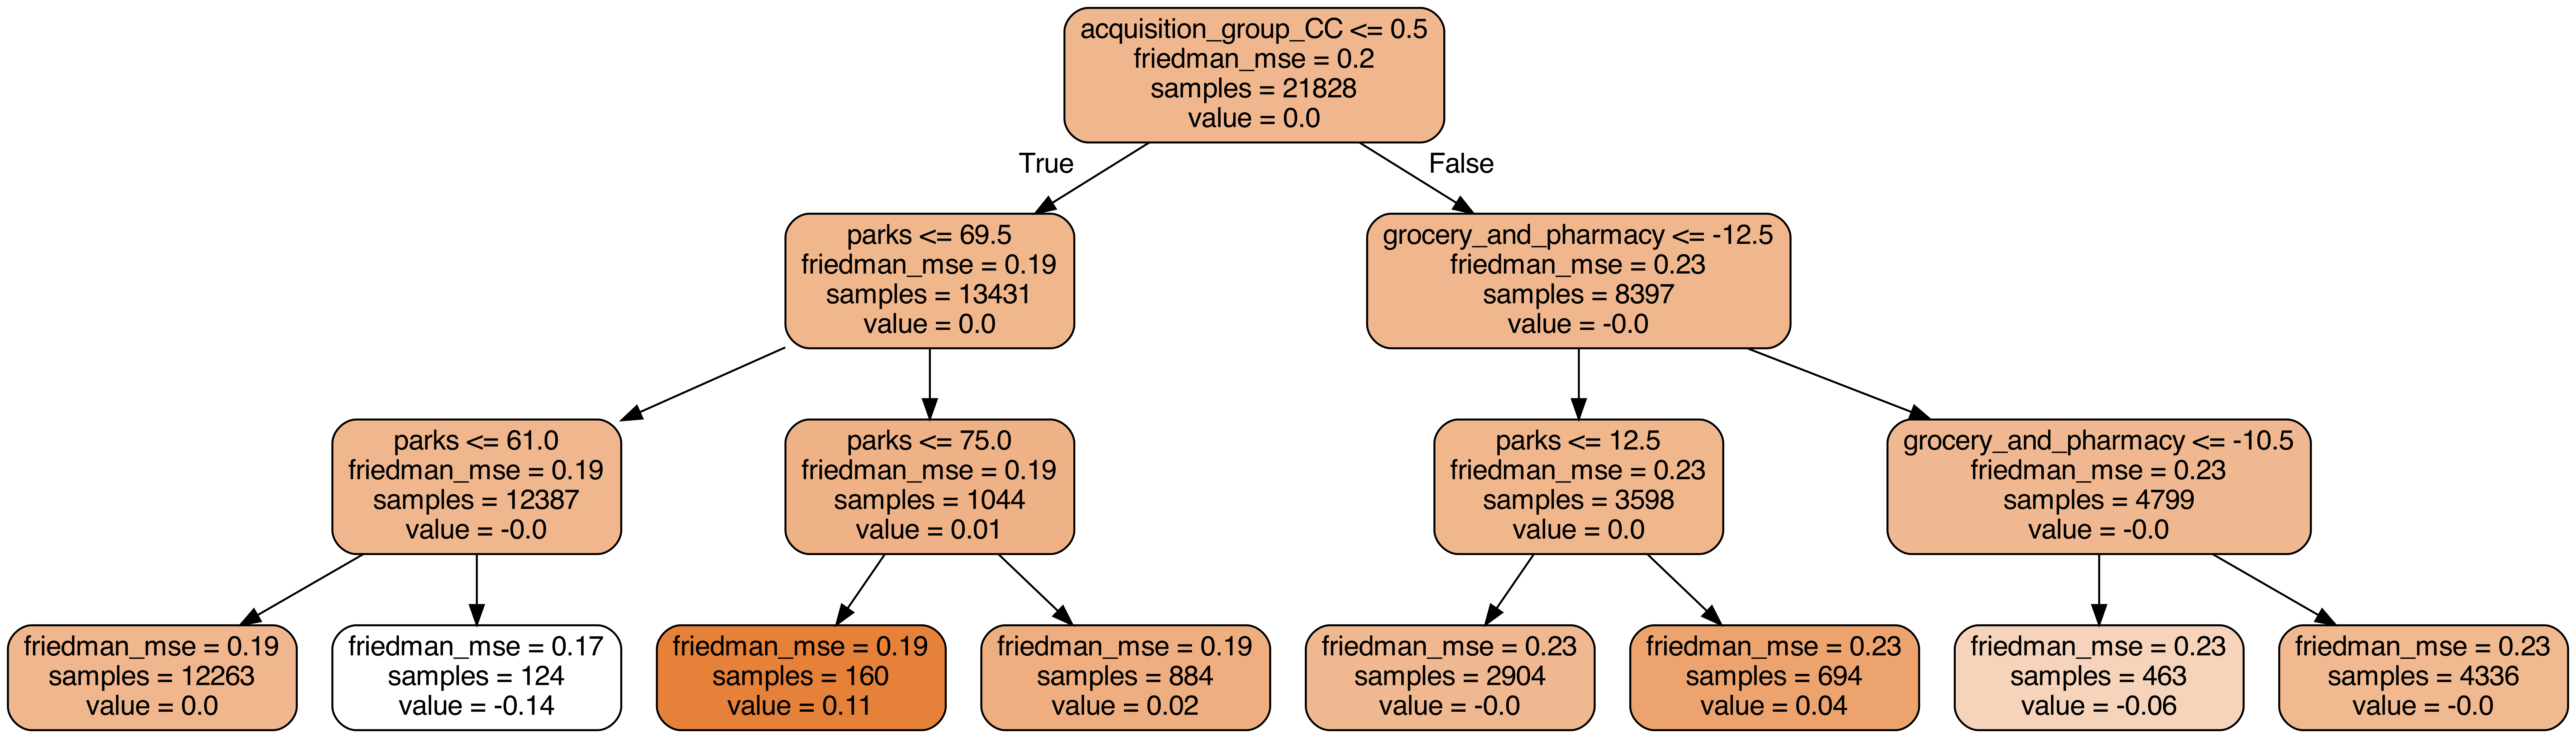

In [27]:
estimator = gb.estimators_[99,2]
export_graphviz(estimator, out_file='boost.dot', 
                feature_names = list(X.columns),
                class_names = ['senior','adult','youth'],
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth=3)
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'boost.dot', '-o', 'boost.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'boost.png')

In [28]:
estimator = rf.estimators_[99]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(X.columns),
                class_names = ['senior','adult','youth'],
                rounded = True, proportion = False, 
                precision = 2, filled = True,max_depth=5)
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

All in all, our statistics were lower than we expected, but we were still able to gather some important information from our model training. Here are a few things:
1. Patients who's outcome wasn't fatal, but acquired the virus from traveling, belong to the `youth` class.
2. Patients in Missisauga who's outcome was identified as unresolved, and acquired the virus from an outbreak, belong to the `senior` class.
3. Most patients who died from the virus are `seniors`, which was expected, while the majority of those who's outcome was resolved were in the `youth` and `adult` classes.
4. In many of the cities, the visits to grocery and pharmacy increased as the fatalities of `seniors` increased. This was something we predicted when we were choosing our features and is the main reason we included it. Also, the visits to parks are much higher when more `youth` and `adult` were classified. Again, this was something we anticipated.
5. Most of the patients where the acquisition was classed as `no known epi link` or `missing information` were classified as `adults`. This could be due to the fact that seniors have people helping them when filling out the forms, while younger people tend to do things on their own and are less strict with the way they do things.